In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data


In [2]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r X_train_scaled
%store -r X_test_scaled 
%store -r X_train_stand
%store -r X_test_stand

target_names = ["CONFIRMED", "FALSE POSITIVE", "CANDIDATE"]
feature_names = X_train.columns

Data normalization or standardization is not performed since the performace of random forest model is not affected by data normalization/standardization

# Decision Tree

In [3]:
from sklearn.metrics import classification_report
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

The default decison tree model causes overfitting

# Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics

In [22]:
rf0 = RandomForestClassifier(random_state=10)
print(f"The cross-validated accuracy for training set:\n{round(cross_val_score(rf0,X_train,y_train,scoring='accuracy', cv=5).mean()*100,2)}%")

The cross-validated accuracy for training set:
89.52%


In [6]:
cross_val_score(rf0,X_train,y_train,scoring='accuracy', cv=5).mean()

0.8952426466484346

In [7]:
rf0 = RandomForestClassifier(oob_score = True, random_state=10)
rf0.fit(X_train, y_train)
print(f"Out of Bag Score: {rf0.oob_score_}")
y_predprob = rf0.predict_proba(X_train) # the probabilities of each class
print(f"AUC Score (Train):{metrics.roc_auc_score(y_train, rf0.predict_proba(X_train), multi_class='ovr')}")

Out of Bag Score: 0.8934126258005489
AUC Score (Train):1.0


The random forest model with default setting achieves a cross-validated accuracy of 89.26%.

# Model Tuning

### 1. n_estimators
First, optimize the model by tuning the number of estimators (number of trees in forest)

In [8]:
# the overall random forest model gets more complex
param_test1 = {'n_estimators':range(10,201,10)} # default: 100
grid1 = GridSearchCV(estimator = RandomForestClassifier(random_state=10, 
                                                        max_features='sqrt'), # auto, same as sqrt 
                       param_grid = param_test1,cv=5, n_jobs = -1)

grid1.fit(X_train, y_train)
grid1.cv_results_['mean_test_score'], grid1.best_params_, grid1.best_score_

(array([0.87908097, 0.89204061, 0.89142981, 0.8929549 , 0.89173562,
        0.89280269, 0.89341303, 0.89356593, 0.89356593, 0.89524265,
        0.89509032, 0.89661541, 0.89615751, 0.8957002 , 0.89692064,
        0.89707343, 0.89737807, 0.89692052, 0.89783562, 0.89707331]),
 {'n_estimators': 190},
 0.8978356216628528)

According to the optimization results, the best hyperparameter for `n_estimators` is 190. The resulted cross-validated accuracy is 89.78%. Compared with the default model (89.52%) where `n_estimator` is 100, the tuned model with `n_estimator` of 190 increases the cross-validated accuracy.

### 2. max_depth
Then, optimze the model by tuning the `max_depth`

In [10]:
# make the model simpler
param_test2 = {'max_depth':range(2,51,2)} # default = none
grid2 = GridSearchCV(estimator = RandomForestClassifier(random_state = 10,
                                                        n_estimators = 190,  
                                                        max_features = 'sqrt'),
                       param_grid = param_test2, cv=5, n_jobs = -1)

grid2.fit(X_train, y_train)
grid2.cv_results_['mean_test_score'], grid2.best_params_, grid2.best_score_

(array([0.74885793, 0.8539176 , 0.8737406 , 0.88319508, 0.88990496,
        0.89188783, 0.89387116, 0.89615833, 0.89402302, 0.89615856,
        0.89707378, 0.89737865, 0.89615879, 0.89646309, 0.89783597,
        0.89631088, 0.89783539, 0.89768307, 0.89798818, 0.89768307,
        0.89783562, 0.89783562, 0.89783562, 0.89783562, 0.89783562]),
 {'max_depth': 38},
 0.8979881769641495)

In [12]:
param_test2_1 = {'max_depth':[37,38,39]} # default = none
grid2_1 = GridSearchCV(estimator = RandomForestClassifier(random_state = 10,
                                                        n_estimators = 190,  
                                                        max_features = 'sqrt'),
                       param_grid = param_test2_1, cv=5, n_jobs = -1)

grid2_1.fit(X_train, y_train)
grid2_1.cv_results_['mean_test_score'], grid2_1.best_params_, grid2_1.best_score_

(array([0.89783562, 0.89798818, 0.89798818]),
 {'max_depth': 38},
 0.8979881769641495)

The best `max_depth` estimator is 38. The resulted cross-validated accuracy is 89.80%, which is increased compared to the default model where `max_depth` is None. Introducing the `max_depth` makes the model simpler, weakening the overfitting effects. 

As introducing restriction on `max_depth` simplifies the model and increases the accuracy, we want to try to simplify the model further by adding limitations into `min_samples_leaf`.

### 3. min_samples_leaf

Then, optimze the model by tuning the `min_samples_leaf`

In [14]:
# make the model simpler
param_test3 = {'min_samples_leaf': range(1, 1+10, 1)}
grid3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 190,
                                                        random_state = 10,
                                                        max_depth = 38
                                                           ), 
                       param_grid = param_test3,cv=5, n_jobs = -1)

grid3.fit(X_train, y_train)
grid3.cv_results_['mean_test_score'], grid3.best_params_, grid3.best_score_

(array([0.89798818, 0.89463347, 0.8915833 , 0.89387046, 0.89097307,
        0.88990565, 0.89188794, 0.88883823, 0.88731396, 0.88594061]),
 {'min_samples_leaf': 1},
 0.8979881769641495)

The accuracy reaches it's relative best  when the `min_samples_leaf` is 1 (default). Increasing `min_samples_leaf` (simplyfying the model) does not improve the model performace. As a result, we next consider making the model more complex by increasing the `max_features`.

### 4. max_features 
Then, optimze the model by tuning the `max_features`

In [15]:
# make the model more complex
param_test4 = {'max_features':range(6,35,2)}
grid4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 190,
                                                        random_state = 10,
                                                        max_depth = 38,
                                                        min_samples_leaf = 1
                                                           ), 
                       param_grid = param_test4,cv=5, n_jobs = -1)

grid4.fit(X_train, y_train)
grid4.cv_results_['mean_test_score'], grid4.best_params_, grid4.best_score_

(array([0.89798818, 0.90119044, 0.90042825, 0.90225821, 0.90286844,
        0.90256263, 0.90180008, 0.90088615, 0.90134381, 0.90225845,
        0.89966559, 0.90073347, 0.90180159, 0.90164834, 0.90073336]),
 {'max_features': 14},
 0.9028684350058602)

In [16]:
param_test4_1 = {'max_features':[13,14,15]}
grid4_1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 190,
                                                        random_state = 10,
                                                        max_depth = 38,
                                                        min_samples_leaf = 1
                                                           ), 
                       param_grid = param_test4_1,cv=5, n_jobs = -1)

grid4_1.fit(X_train, y_train)
grid4_1.cv_results_['mean_test_score'], grid4_1.best_params_, grid4.best_score_

(array([0.90164776, 0.90286844, 0.90088556]),
 {'max_features': 14},
 0.9028684350058602)

The best accuracy is increased from 89.60% to 90.62%. The best `max_features` is increased to 13, compared to the default `max_features` of 6 (sqrt(# of features)), which makes the model more complicated. That means the model may be optimzed further by making the model more complex.

Finally, we get the optimzed random forest model.

In [17]:
tuned_rf = RandomForestClassifier(random_state=10,
                                  n_estimators = 190,
                                  max_depth = 38,
                                  min_samples_leaf = 1,
                                  max_features = 14)
print(f"The cross-validated accuracy based on the tuned random forest model:\n{round(cross_val_score(tuned_rf,X_train,y_train,scoring='accuracy', cv=5).mean()*100,2)}%")

The cross-validated accuracy based on the tuned random forest model:
90.29%


## Feature importance

In [18]:
tuned_rf.fit(X_train, y_train)
sorted(zip(tuned_rf.feature_importances_, feature_names), reverse=True)

[(0.14956394830996425, 'koi_fpflag_nt'),
 (0.14927948317432024, 'koi_fpflag_co'),
 (0.09968088482852208, 'koi_fpflag_ss'),
 (0.08048964987131307, 'koi_model_snr'),
 (0.051779664796624686, 'koi_prad'),
 (0.04342340220919032, 'koi_fpflag_ec'),
 (0.03224435172113768, 'koi_duration_err2'),
 (0.030356773519156523, 'koi_duration_err1'),
 (0.028371121676290346, 'koi_prad_err2'),
 (0.02527550423780938, 'koi_prad_err1'),
 (0.02326965336611044, 'koi_duration'),
 (0.022465316065056345, 'koi_steff_err1'),
 (0.01872493909795845, 'koi_period'),
 (0.01450316416077089, 'koi_steff_err2'),
 (0.014501176415867805, 'koi_impact'),
 (0.013877111744984192, 'koi_time0bk_err1'),
 (0.012625994241287386, 'koi_depth'),
 (0.011921340935505056, 'koi_time0bk_err2'),
 (0.011571018463378694, 'ra'),
 (0.01124369754321312, 'koi_time0bk'),
 (0.01002983689432325, 'koi_depth_err1'),
 (0.00991565541542975, 'koi_period_err2'),
 (0.009797130559866595, 'dec'),
 (0.009688150371604172, 'koi_depth_err2'),
 (0.009521197472890834, 

In [19]:
feature_list = list(sorted(zip(tuned_rf.feature_importances_, feature_names),reverse = True))
feature_counts = len(feature_list)

important_features = []
for i in range(feature_counts):
    if feature_list[i][0] > 0.01:
        important_features.append(feature_list[i][1])

important_features

['koi_fpflag_nt',
 'koi_fpflag_co',
 'koi_fpflag_ss',
 'koi_model_snr',
 'koi_prad',
 'koi_fpflag_ec',
 'koi_duration_err2',
 'koi_duration_err1',
 'koi_prad_err2',
 'koi_prad_err1',
 'koi_duration',
 'koi_steff_err1',
 'koi_period',
 'koi_steff_err2',
 'koi_impact',
 'koi_time0bk_err1',
 'koi_depth',
 'koi_time0bk_err2',
 'ra',
 'koi_time0bk',
 'koi_depth_err1']

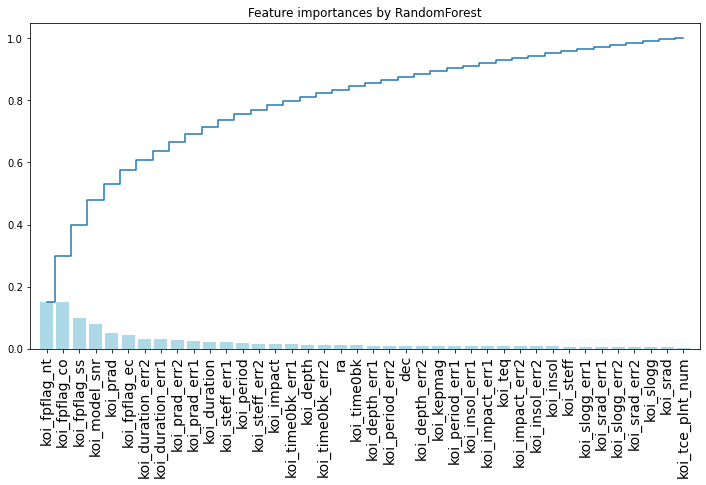

In [20]:
importances = tuned_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Save the optimzed random forest model

In [21]:
import joblib
filename = "random_forest2.sav"
joblib.dump(tuned_rf, filename)

['random_forest2.sav']